In [1]:
## PROJECTS Unsupervised Machine Learning
## Uber Pickups

In [2]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import  silhouette_score
from datetime import datetime

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import seaborn as sn
pio.renderers.default = "vscode"

In [3]:
#### uber-raw-data-apr14
data_01 = pd.read_csv("Resources/uber-raw-data-apr14.csv")
data_01.head()

Date/Time      Lat      Lon    Base
0  4/1/2014 0:11:00  40.7690 -73.9549  B02512
1  4/1/2014 0:17:00  40.7267 -74.0345  B02512
2  4/1/2014 0:21:00  40.7316 -73.9873  B02512
3  4/1/2014 0:28:00  40.7588 -73.9776  B02512
4  4/1/2014 0:33:00  40.7594 -73.9722  B02512

In [4]:
# Voir les variables avec des données vident
data_01.isnull().sum()

Date/Time    0
Lat          0
Lon          0
Base         0
dtype: int64

## Trie des dates 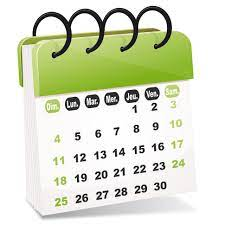

In [5]:
# Convertir la chaîne de caractères en objet datetime
data_01['Date/Time'] = pd.to_datetime(data_01['Date/Time'])

# Extraire l'année, le mois, le jour et le jour de la semaine
data_01['Date'] = data_01['Date/Time'].dt.date
data_01['Time'] = data_01['Date/Time'].dt.time

In [6]:
# Drop la colonne Date/Time
data_01 = data_01.drop(columns = ['Date/Time'])
data_01.head()

Lat      Lon    Base        Date      Time
0  40.7690 -73.9549  B02512  2014-04-01  00:11:00
1  40.7267 -74.0345  B02512  2014-04-01  00:17:00
2  40.7316 -73.9873  B02512  2014-04-01  00:21:00
3  40.7588 -73.9776  B02512  2014-04-01  00:28:00
4  40.7594 -73.9722  B02512  2014-04-01  00:33:00

In [7]:
# Convertir la chaîne de caractères en objet datetime
data_01['Date'] = pd.to_datetime(data_01['Date'])

# Extraire les jours de la semaine 
data_01['Dayofweek'] = data_01['Date'].dt.dayofweek
data_01.head()

Lat      Lon    Base       Date      Time  Dayofweek
0  40.7690 -73.9549  B02512 2014-04-01  00:11:00          1
1  40.7267 -74.0345  B02512 2014-04-01  00:17:00          1
2  40.7316 -73.9873  B02512 2014-04-01  00:21:00          1
3  40.7588 -73.9776  B02512 2014-04-01  00:28:00          1
4  40.7594 -73.9722  B02512 2014-04-01  00:33:00          1

In [8]:
# Voir la distribution de la nouvelle colonne "Cat"
data = data_01['Dayofweek'].value_counts()
data

Dayofweek
2    108631
1     91185
4     90303
3     85067
5     77218
0     60861
6     51251
Name: count, dtype: int64

## Trie des heures 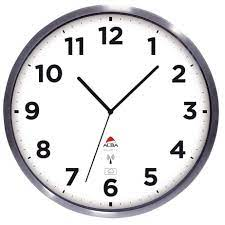

In [9]:
# Fonction pour attribuer une lettre en fonction de l'heure
def assign_letter(hour):
    if hour < 6:
        return 'A'
    elif hour < 12:
        return 'B'
    elif hour < 18:
        return 'C'
    else:
        return 'D'

In [10]:
# Ajout de la colonne "Cat" avec les lettres attribuées
data_01['Cat_Time'] = data_01['Time'].apply(lambda x: assign_letter(x.hour))
data_01.head()

Lat      Lon    Base       Date      Time  Dayofweek Cat_Time
0  40.7690 -73.9549  B02512 2014-04-01  00:11:00          1        A
1  40.7267 -74.0345  B02512 2014-04-01  00:17:00          1        A
2  40.7316 -73.9873  B02512 2014-04-01  00:21:00          1        A
3  40.7588 -73.9776  B02512 2014-04-01  00:28:00          1        A
4  40.7594 -73.9722  B02512 2014-04-01  00:33:00          1        A

In [11]:
# Distribution de la nouvelle colonne "Cat"
data = data_01['Cat_Time'].value_counts()
data

Cat_Time
D    206428
C    192020
B    120843
A     45225
Name: count, dtype: int64

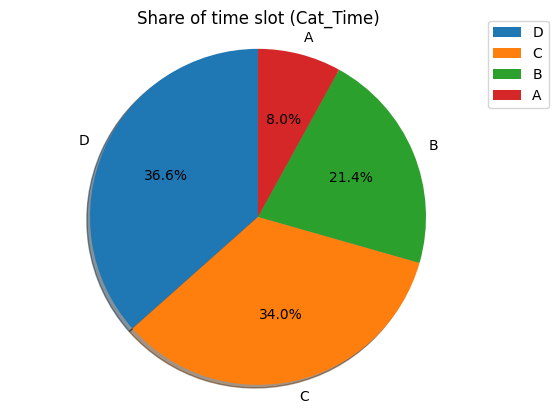

In [12]:
# Voir la distribution de la nouvelle colonne "Cat" en graphique
### "A" 00H00 / 06H00  -- "B" 06H00 / 12H00  -- "C" 12H00 / 18H00  -- "D" 18H00 / 00H00
plt.figure()
plt.pie(data.values, labels=data.index,
       autopct='%1.1f%%',
       shadow=True,
       startangle=90,
       radius=1.5
       )
plt.axis('equal')
plt.title('Share of time slot (Cat_Time)')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

## Test de K-mean avec les "Dayofweek=0" soit lundi

In [13]:
# Filtrer les lignes avec Dayofweek=0 et Cat_Time='A'
data_01_lundi = data_01[(data_01['Dayofweek'] == 0)]
data_01_lundi.head()

Lat      Lon    Base       Date      Time  Dayofweek Cat_Time
7785  40.7205 -73.9939  B02512 2014-04-07  00:31:00          0        A
7786  40.7407 -74.0077  B02512 2014-04-07  00:37:00          0        A
7787  40.7591 -73.9892  B02512 2014-04-07  00:50:00          0        A
7788  40.7419 -74.0034  B02512 2014-04-07  00:58:00          0        A
7789  40.7419 -74.0034  B02512 2014-04-07  01:27:00          0        A

In [14]:
# Distribution de la variable data_01_filtered
data_01_lundi.shape

(60861, 7)

## Lancement de Kmean avec "data_01_lundi"

In [17]:
# Traitements
numeric_features = [0, 1] # Positions des colonnes quantitatives dans X
numeric_transformer = StandardScaler()

# Création du transformer pour les variables catégorielles
categorical_features = [2,3,4,5,6] # Positions des colonnes catégorielles dans X
categorical_transformer = OneHotEncoder(drop='first')

# On combine les transformers dans un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Preprocessings sur le dataset
print("Preprocessing sur le train set...")
print(data_01_lundi.head())
X_data_01_lundi = preprocessor.fit_transform(data_01_lundi) # fit_transform !!
print('...Terminé.')
print(X_data_01_lundi[0:5, :])
print()

Preprocessing sur le train set...
          Lat      Lon    Base       Date      Time  Dayofweek Cat_Time
7785  40.7205 -73.9939  B02512 2014-04-07  00:31:00          0        A
7786  40.7407 -74.0077  B02512 2014-04-07  00:37:00          0        A
7787  40.7591 -73.9892  B02512 2014-04-07  00:50:00          0        A
7788  40.7419 -74.0034  B02512 2014-04-07  00:58:00          0        A
7789  40.7419 -74.0034  B02512 2014-04-07  01:27:00          0        A
...Terminé.
  (0, 0)	-0.5194135485764583
  (0, 1)	-0.36826967144379985
  (0, 39)	1.0
  (1, 0)	0.009376907000891369
  (1, 1)	-0.611309411897295
  (1, 45)	1.0
  (2, 0)	0.49104742099224
  (2, 1)	-0.28549526708647543
  (2, 58)	1.0
  (3, 0)	0.04079020139174472
  (3, 1)	-0.5355796376980249
  (3, 66)	1.0
  (4, 0)	0.04079020139174472
  (4, 1)	-0.5355796376980249
  (4, 95)	1.0



### Elbow method 💪

In [ ]:
# Let's create a loop that will collect the Within-sum-of-square (wcss) for each value K
# Let's use .inertia_ parameter to get the within sum of square value for each value K
wcss_data_01_lundi =  []
k_data_01_lundi = []
for i in range (2,11):
    kmeans = KMeans(n_clusters= i, random_state = 0, n_init = 'auto')
    kmeans.fit(X_data_01_lundi)
    wcss_data_01_lundi.append(kmeans.inertia_)
    k_data_01_lundi.append(i)
    print("WCSS for K={} --> {}".format(i, wcss_data_01_lundi[-1]))

In [ ]:
# Create DataFrame
wcss_frame_lundi = pd.DataFrame(wcss_data_01_lundi)
k_frame_lundi = pd.Series(k_data_01_lundi)

# Create figure
fig= px.line(
    wcss_frame_lundi,
    x=k_frame_lundi,
    y=wcss_frame_lundi.iloc[:,-1]
)

# Create title and axis labels
fig.update_layout(
    yaxis_title="Inertia",
    xaxis_title="# Clusters",
    title="Inertia per cluster"
)

# Render
#fig.show(renderer="notebook")
fig.show() # if using workspace

## Silhouette 👥

In [ ]:
# Computer mean silhouette score
sil_lundi = []
k_lundi = []

## Careful, you need to start at i=2 as silhouette score cannot accept less than 2 labels
for i in range (2,11):
    kmeans_lundi = KMeans(n_clusters= i, random_state = 0, n_init = 'auto')
    kmeans_lundi.fit(X_data_01_lundi)
    sil_lundi.append(silhouette_score(X_data_01_lundi, kmeans_lundi.predict(X_data_01_lundi)))
    k_lundi.append(i)
    print("Silhouette score for K={} is {}".format(i, sil_lundi[-1]))

In [ ]:
# Create a data frame
cluster_scores_lundi=pd.DataFrame(sil_lundi)
k_frame_lundi = pd.Series(k_lundi)

# Create figure
fig = px.bar(data_frame=cluster_scores_lundi,
             x=k_lundi,
             y=cluster_scores_lundi.iloc[:, -1]
            )

# Add title and axis labels
fig.update_layout(
    yaxis_title="Silhouette Score",
    xaxis_title="# Clusters",
    title="Silhouette Score per cluster"
)

# Render
#fig.show(renderer="notebook")
fig.show() # if using workspace

In [ ]:
# On ré-entraîne un KMeans avec le nombre optimal de clusters
kmeans = KMeans(n_clusters= 3, n_init = "auto")
kmeans.fit(X_data_01_lundi)

In [ ]:
# Ajout de la colonne "Cluster_KMeans" dans le Dataframe "data_01_filtered"
data_01_lundi.loc[:,'Cluster_KMeans'] = kmeans.predict(X_data_01_lundi)
data_01_lundi.head()

In [ ]:
# Voir le nouveau dataframe
data_01_lundi.head()

In [ ]:
# Distribution de la nouvelle colonne "Cat" pour le lundi du moi d'avril 
data_lundi = data_01_lundi['Cat_Time'].value_counts()
data_lundi

In [ ]:
# Voir la distribution de la nouvelle colonne "Cat" en graphique
### "A" 00H00 / 06H00  -- "B" 06H00 / 12H00  -- "C" 12H00 / 18H00  -- "D" 18H00 / 00H00
plt.figure()
plt.pie(data_lundi.values, labels=data_lundi.index,
       autopct='%1.1f%%',
       shadow=True,
       startangle=90,
       radius=1.5
       )
plt.axis('equal')
plt.title('Share of time slot on Monday (Cat_Time)')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

In [ ]:
# On utilise scatter_mapbox pour visualiser notre graphique
fig = px.scatter_mapbox(data_frame=data_01_lundi, lat='Lat', lon='Lon', color='Cluster_KMeans', mapbox_style="carto-positron")
fig.show()

## Lancement de DBScan avec "data_01_lundi"

In [15]:
# Distribution des points
fig = px.scatter_mapbox(
        data_01_lundi,
        lat="Lat",
        lon="Lon",
        color="Cat_Time",
        mapbox_style="carto-positron"
)

fig.show()

In [135]:
# Utilisation de DBScan sur les lundi du mois d'avril 
db_lundi = DBSCAN(eps=0.5, min_samples=2, metric="manhattan")
db_lundi.fit(X_data_01_lundi)

DBSCAN(metric='manhattan', min_samples=2)

In [136]:
# Afficher combien de clusters DBSCAN a créés
np.unique(db_lundi.labels_)

array([  -1,    0,    1, ..., 9383, 9384, 9385], dtype=int64)

In [137]:
data_01_lundi["Cluster_DBSCAN"] = db_lundi.labels_
data_01_lundi.head()

C:\Users\LABEAUG\AppData\Local\Temp\ipykernel_30800\1177328282.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Lat      Lon    Base       Date      Time  Dayofweek Cat_Time  \
7785  40.7205 -73.9939  B02512 2014-04-07  00:31:00          0        A   
7786  40.7407 -74.0077  B02512 2014-04-07  00:37:00          0        A   
7787  40.7591 -73.9892  B02512 2014-04-07  00:50:00          0        A   
7788  40.7419 -74.0034  B02512 2014-04-07  00:58:00          0        A   
7789  40.7419 -74.0034  B02512 2014-04-07  01:27:00          0        A   

      Cluster_DBSCAN  
7785              -1  
7786              -1  
7787              -1  
7788              -1  
7789              -1

In [138]:
# Visualiser les Clusters
fig = px.scatter_mapbox(
        data_01_lundi[data_01_lundi.Cluster_DBSCAN != -1],
        lat="Lat",
        lon="Lon",
        color="Cluster_DBSCAN",
        mapbox_style="carto-positron"
)

fig.show()